In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from astropy.timeseries import LombScargle
from scipy import optimize
from scipy.ndimage import gaussian_filter
import glob
import lightkurve as lk

def estimate_frequencies(
    x, y, fmin=None, fmax=None, max_peaks=3, oversample=4.0, optimize_freq=True
):
    tmax = x.max()
    tmin = x.min()
    dt = np.median(np.diff(x))
    df = 1.0 / (tmax - tmin)
    ny = 0.5 / dt
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 2*ny
    freq = np.arange(fmin, fmax, df / oversample)
    power = LombScargle(x, y).power(freq)
    # Find peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power) - 1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for j in range(max_peaks):
        i = peak_inds[0]
        freq0 = freq[i]
        alias = 2.0 * ny - freq0
        m = np.abs(freq[peak_inds] - alias) > 25 * df
        m &= np.abs(freq[peak_inds] - freq0) > 25 * df
        peak_inds = peak_inds[m]
        peaks.append(freq0)
    peaks = np.array(peaks)
    if optimize_freq:
        def chi2(nu):
            arg = 2 * np.pi * nu[None, :] * x[:, None]
            D = np.concatenate([np.cos(arg), np.sin(arg), np.ones((len(x), 1))], axis=1)
            # Solve for the amplitudes and phases of the oscillations
            DTD = np.matmul(D.T, D)
            DTy = np.matmul(D.T, y[:, None])
            w = np.linalg.solve(DTD, DTy)
            model = np.squeeze(np.matmul(D, w))
            chi2_val = np.sum(np.square(y - model))
            return chi2_val
        res = optimize.minimize(chi2, [peaks], method="L-BFGS-B")
        return res.x
    else:
        return peaks
    
    
def amplitude_spectrum(t, y, fmin=None, fmax=None, freq=None, oversample_factor=10.0):
    """ 
    Calculates the amplitude spectrum of a given signal
    
    Parameters
    ----------
        t : `array`
            Time values 
        y : `array`
            Flux or magnitude measurements
        fmin : float (default None)
            Minimum frequency to calculate spectrum. Defaults to df
        fmax : float
            Maximum frequency to calculate spectrum. Defaults to Nyquist.
        oversample_factor : float
            Amount by which to oversample the spectrum. Defaults to 10.
    """
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult
    if freq is None:
        freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
import tqdm
import pymc3 as pm
from pymc3.model import Model
import exoplanet as xo
from exoplanet.orbits import get_true_anomaly
from astropy.timeseries import LombScargle

__all__ = ["Periodogram"]


class Periodogram:
    """A class to brute force the likelihood in search of small signals.
    For each orbital period, it will iterate over a simplified Maelstrom
    model, optimise the values, and then record the loglikelihood. 
    This is useful for planets, and short period binaries.
    
    Args:
        time (array): Time values
        mag (array): Magnitude (or flux) values. Must be relative
        freq (array): Array of frequencies
    """

    def __init__(self, time, mag, freq):

        self.time = time
        self.mag = mag
        self.freq = freq
        # Initialise the model
        self.model = pm.Model()

        self.results = []

        with self.model as model:
            period = pm.Flat("period", testval=10.0)
            nu = pm.Flat("nu", testval=15)

            phi = xo.distributions.Angle("phi")
            logasini = pm.Uniform(
                "logasini", lower=np.log(1), upper=np.log(1000), testval=np.log(10)
            )
            drift = pm.Normal("drift", mu=0, sd=1.0)

            M = 2.0 * np.pi * self.time / period - phi

            factor = 2.0 * np.pi * nu
            A = factor * (1 + drift) * self.time
            B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)

            sinarg = tt.sin(A + B)
            cosarg = tt.cos(A + B)

            DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
            w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, self.mag))
            pm.Deterministic("w", w)
            pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
            lc_model = tt.dot(DT.T, w)

            pm.Normal("obs", mu=lc_model, observed=self.mag)

            self.fit_params = [v for v in model.vars if v.name not in ["period", "nu"]]

    def _run_fit(self, p, nu):
        with self.model as model:
            start = dict(model.test_point)
            start["period"] = p
            start["nu"] = nu
            point, info = xo.optimize(
                start, vars=self.fit_params, return_info=True, verbose=False
            )
        return -info.fun, point

    def fit(self, periods):
        """Run the periodogram model for a given array of periods.
        
        Args:
            periods (array): Orbital periods over which to iterate.
        
        Returns:
            array: Results
        """
        results = []
        for f in self.freq:
            results.append([self._run_fit(p, f) for p in tqdm.tqdm(periods)])
        self.results = results
        self.periods = periods
        return self.results

    def diagnose(self):
        """Generate diagnostic plots of the fit values. After running 
        `Periodogram.fit()`, `diagnose` will plot the resulting period vs 
        likelihood and period vs optimised asini values.
        
        Returns:
            array: array of matplotlib axes.
        """
        results = self.results
        fig, axes = plt.subplots(1, 2, figsize=[11, 4])

        ax = axes[0]
        ys = np.array([[r[0] for r in row] for row in results])
        sm = np.sum(ys, axis=0)
        period_ind = np.argmax(sm)
        ax.plot(self.periods, sm)
        ax.axvline(self.periods[period_ind], c="red", linestyle="dashed")
        ax.set_xlabel("Period [day]")
        ax.set_ylabel("Model likelihood")
        ax.set_xlim(self.periods[0], self.periods[-1])

        ax = axes[1]
        ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
        ax.plot(self.periods, ys.T)
        ax.set_xlabel("Period [day]")
        ax.set_ylabel("asini (s)")
        ax.set_xlim(self.periods[0], self.periods[-1])

        return axes
    
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        y : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag, ft_real))
    return phase

def get_time_delay(time, flux, freq, segment_size=10.):
    """ 
    Calculates the time delay signal, splitting the light curve into 
    chunks of width segment_size. A smaller segment size will increase
    the scatter of the time delay signal, especially for low frequencies.

    Parameters
    ----------
    segment_size : `float`
        Segment size in which to separate the light curve, in units of
        the light curve time. For example, the default segment size of 10 
        will separate a 1000 d long light curve in 100 segments of 10 d
        each.

    Returns
    -------
    time_midpoint : `numpy.ndarray`
        Midpoints of time for each segment in the light curve
    time_delay: `numpy.ndarray`
        Values of the extracted time delay in each segment.
    """
    uHz_conv = 1e-6 * 24 * 60 * 60
    time_0 = time[0]
    time_slice, mag_slice, phase = [], [], []
    time_delays, time_midpoints = [], []

    # Iterate over lightcurve
    for t, y in zip(time, flux):
        time_slice.append(t)
        mag_slice.append(y)

        # In each segment
        if t - time_0 > segment_size:
            # Append the time midpoint
            time_midpoints.append(np.mean(time_slice))

            # And the phases for each frequency
            phase.append(dft_phase(time_slice, mag_slice, freq))
            time_0 = t
            time_slice, mag_slice = [], []

    phase = np.array(phase).T
    # Phase wrapping patch
    for ph, f in zip(phase, freq):
        ph = np.unwrap(ph)
        ph -= np.mean(ph)

        td = ph / (2 * np.pi * (f / uHz_conv * 1e-6))
        time_delays.append(td)
    time_delays = np.array(time_delays)
    return np.array(time_midpoints), np.array(time_delays)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
#
# 
# Orbital Period [days],Transit Epoch [BKJD]
# 155.046089±0.001509,166.60575±0.00915


In [200]:
lc = lk.search_lightcurve('KIC 4253860', mission='Kepler', cadence='long').download_all().stitch().remove_nans()

# good example: 4253860
# 9837659 ? 

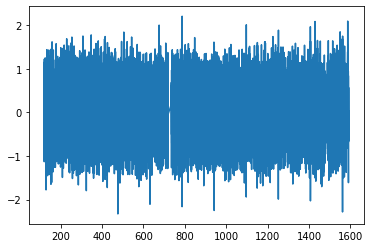

In [226]:
lc = lc.remove_outliers()
x, y = lc.time.value, lc.flux.value - 1.
y *= 1e3
# y = y - gaussian_filter(y, 1)
plt.plot(x, y)

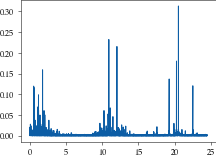

In [279]:
f, a = amplitude_spectrum(x, y)
freqs = estimate_frequencies(x, y, fmin=5, fmax=40, max_peaks=3)
plt.plot(f,a)


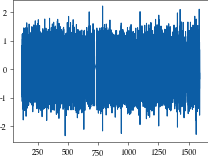

In [280]:
plt.plot(x, y)

In [281]:
freqs

array([20.50807082, 10.9147824 , 12.03056777])

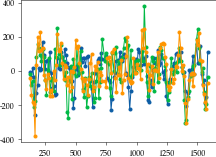

In [283]:
t_mid, td = get_time_delay(x, y, freqs[:4], segment_size=10)
plt.plot(t_mid, td[[0,1,2]].T, '.-');

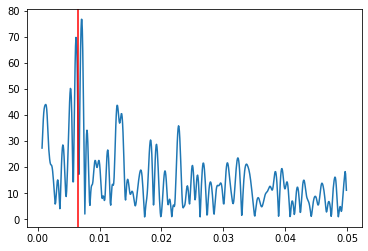

In [219]:
plt.plot(*amplitude_spectrum(t_mid, td[3]))
plt.axvline(1/155.0454, c='r')

/home/daniel/anaconda3/lib/python3.8/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


(-1.0, 1.0)

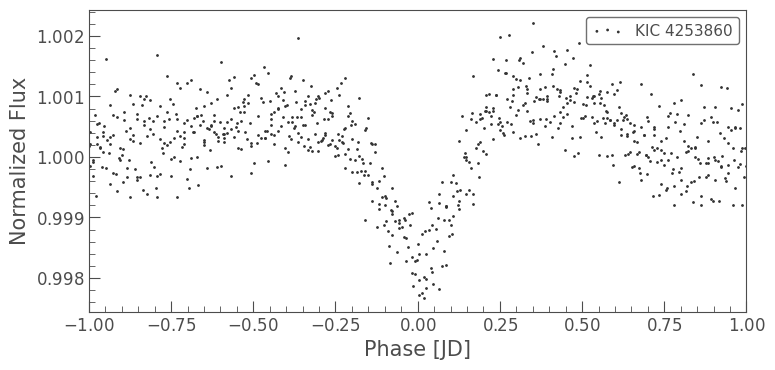

In [230]:
ax = lc.fold(155.046089, t0=166.60575).scatter()
ax.set_xlim(-1, 1)

In [231]:
from balmung import Balmung
time, flux = x, y
bm = Balmung(time, flux)
bm.prewhiten(fmin=1, maxiter=100)

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


In [232]:
import seaborn as sns

ccs = sns.color_palette("Reds", len(bm.removed))[::-1]

In [233]:
Porb, t0 = 155.046089,166.60575

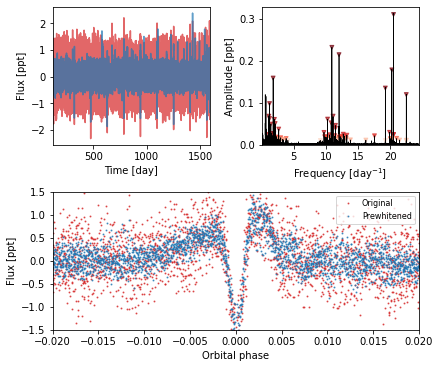

In [234]:
axes = plt.figure(figsize=[6, 5], constrained_layout=True).subplot_mosaic(
    """
    AB
    CC
    """
)

ax = axes['A']
ax.plot(bm.time, bm.flux, c='C3', alpha=0.7)
ax.plot(bm.time, bm.residual, c='C0', alpha=0.7)
ax.set(xlim=[bm.time[0], bm.time[-1]], xlabel='Time [day]', ylabel='Flux [ppt]')

ax = axes['B']
f,a = amplitude_spectrum(bm.time, bm.flux)
ax.plot(f,a, 'k', lw=0.7)
ax.scatter(np.array(bm.removed)[:,0], np.array(bm.removed)[:,1], marker='v', color=ccs, alpha=0.7, s=15, rasterized=True)
ax.set(xlim=(f[0], f[-1]), ylim=(0, None), xlabel=r'Frequency [day$^{-1}$]', ylabel='Amplitude [ppt]')

ax = axes['C']
phase = (t0 % Porb) / Porb    
fold_time = (((x - phase * Porb) / Porb) % 1)
fold_time[fold_time > 0.5] -= 1
sort = np.argsort(fold_time)
ax.plot(fold_time[sort], bm.flux[sort], '.', c='C3', alpha=0.7, markersize=2, label='Original', rasterized=True)
ax.plot(fold_time[sort], bm.residual[sort], '.', c='C0', alpha=0.7,markersize=2, label='Prewhitened', rasterized=True)
ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-1.5, 1.5)
ax.set(xlabel='Orbital phase', ylabel='Flux [ppt]')
ax.legend(fontsize=8, frameon=True, fancybox=True)


In [254]:
plt.style.use('science')
ccs = sns.color_palette("Reds", len(td))[::-1]

In [328]:
Porb

155.046089

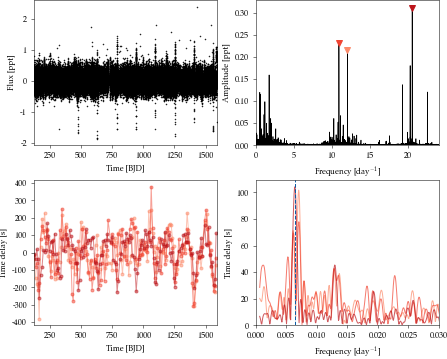

In [327]:
fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=[6.3,5])
axes = axes.flatten()
ax = axes[0]
ax.plot(bm.time, bm.residual, '.k', markersize=1, rasterized=True)

ax = axes[1]
ax.plot(f, a, 'k', lw=0.7)
ax.set(xlim=[0,24], ylim=[0,None])
amps = [np.sqrt(LombScargle(x, y).power(freq, method="fast", normalization="psd")) * np.sqrt(4.0 / len(x)) for freq in freqs]

for i in range(len(td)):
    axes[2].plot(t_mid, td[i], '.-', c=ccs[i],zorder=1-i, alpha=0.5);
    axes[3].plot(*amplitude_spectrum(t_mid, td[i]), alpha=0.7,c=ccs[i],zorder=1-i)
    axes[1].plot(freqs[i], amps[i], 'v', color=ccs[i], alpha=1)

axes[3].axvline(1/Porb, c='C0', lw=1, linestyle='dashed')


axes[0].set(xlim=[x[0], x[-1]], xlabel='Time [BJD]', ylabel='Flux [ppt]')
axes[1].set(xlabel=r'Frequency [day$^{-1}$]', ylabel='Amplitude [ppt]')
axes[2].set(xlim=[x[0], x[-1]], xlabel='Time [BJD]', ylabel='Time delay [s]')
axes[3].set(xlabel=r'Frequency [day$^{-1}$]', ylabel='Time delay [s]', xlim=[0,0.03], ylim=[0,None])


plt.savefig('pulsation_transit.pdf')

In [304]:
amps

[0.31061688760254935, 0.23224878300815052, 0.21502981562910098]

In [25]:
pg = Periodogram(x, y, freqs)
p = np.geomspace(1, 1000, 200)
res = pg.fit(p)

100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


In [27]:
lnlike = np.array([[r[0] for r in row] for row in res])

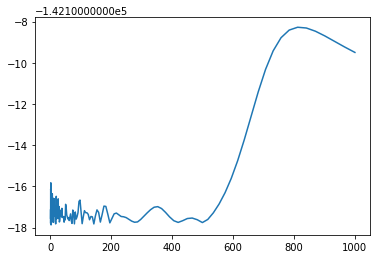

In [28]:
plt.plot(p, lnlike[0])
# for i in range(10):
#     plt.axvline(45.163 * i, c='r')
# plt.xlim(0, 100)

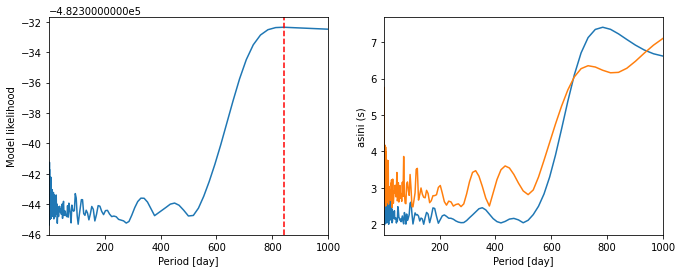

In [29]:
pg.diagnose();